## REBOUND simulation to conform impulse approximation

This notebook is to make sure impulse approximation can describe the HD7977 flyby very well. We use $|\Delta v|$ as a validation metric. In theory, $|\Delta v|$ only depends on the distance from the flyby path to the particle.

$$
\begin{aligned}
|\Delta v| &= \frac{2GM}{v}\frac{1}{|b-rcos\alpha_0|}
&=\frac{2GM}{v}\frac{1}{R}
\end{aligned}
$$

Make sure to run this notebook in Linux.

In [187]:
import rebound
import numpy as np  
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import fsolve

In [ ]:
def t_to_closest_encounter(r, f, omega, y_p, vy_p):
    
    """
    calculate the time for a particle starting at (0, y_p) with velocity (0, vy_p) 
    to encounter another particle at y = r * sin(f + omega * t)
    :param r: the radius of the other particle's orbit
    :param f: the initial phase of the other particle
    :param omega: the angular velocity of the other particle
    :param y_p: the y coordinate of the initial particle
    :param vy_p: the y component of the initial particle's velocity
    :return: the time t when the two particles encounter
    """
    
    def equation(t):
        return r * np.sin(f + omega * t) + y_p - vy_p * t

    initial_guess = 0.1
    solution = fsolve(equation, initial_guess)
    solution = [s for s in solution if s > 0]

    return solution

In [189]:
# set the initial conditions

G = 39.476926421373  # AU^3 / (Msun yr^2)
b = 2300  # AU, calculated from Notebook 1
y_p = 2e4  # AU, we don't care, but just set it to a large number
m_p = 1.07 # Msun
vy_km_s = 26.4482

km_to_au = 1 / 149597870.7
s_to_year = 31557600
conversion_factor = km_to_au * s_to_year

vy_p = vy_km_s * conversion_factor

x = np.linspace(-200, 2000, 1000) + b
f = np.random.uniform(0, 2 * np.pi, 1000)
r = x / np.cos(f)
v = np.sqrt(G * m_p / x)
print(v.mean() / conversion_factor)


# filter out the particles that are too far away

filter = (r > 2000) & (r < 1e4)
x = x[filter]
f = f[filter]
r = r[filter]
v = v[filter]



0.5531505604513176


In [190]:
N_out = 1000
t_max = 1e4
vx0 = []
vx1 = []
x0 = np.zeros(2 * len(x))
time0 = np.zeros(2 * len(x))

# Prograde
for i in tqdm(range(len(x))):  
    sim = rebound.Simulation()  
    sim.units = ('yr', 'AU', 'Msun')
    sim.add(m=1.0, x=0.0, y=0.0, z=0.0, vx=0.0, vy=0.0, vz=0.0, hash=0)
    sim.move_to_com()
    sim.add(m=m_p, x=b, y=-y_p, vy=vy_p, hash=1)
    sim.add(a=r[i], e=0, f=f[i], m=1e-6, primary=sim.particles[0], hash=2)
    w = 2 * np.pi / sim.particles[2].orbit(primary=sim.particles[0]).P
    time00 = t_to_closest_encounter(r[i], f[i], w, y_p, vy_p)
    time0[i] = time00[0] if len(time00) > 0 else 0
    f0 = np.mod(f[i] + w * time0[i], 2 * np.pi)
    x0[i] = r[i] * np.cos(f0)
    sim.integrate(time0[i] - 500)
    vx0.append(sim.particles[2].vx)
    sim.integrate(time0[i] + 500)
    vx1.append(sim.particles[2].vx)
    
# Retrograde
for i in tqdm(range(len(x))):  
    sim = rebound.Simulation()  
    sim.units = ('yr', 'AU', 'Msun')
    sim.add(m=1.0, x=0.0, y=0.0, z=0.0, vx=0.0, vy=0.0, vz=0.0, hash=0)
    sim.move_to_com()
    sim.add(m=m_p, x=b, y=-y_p, vy=vy_p, hash=1)
    sim.add(a=r[i], e=0, f=f[i], m=1e-6, primary=sim.particles[0], hash=2)
    particle = sim.particles[2]
    vx, vy, vz = particle.vx, particle.vy, particle.vz
    particle.vx = -vx
    particle.vy = -vy
    w = 2 * np.pi / sim.particles[2].orbit(primary=sim.particles[0]).P
    time00 = t_to_closest_encounter(r[i], f[i], w, y_p, vy_p)
    time0[i + len(x)] = time00[0] if len(time00) > 0 else 0
    f0 = np.mod(f[i] - w * time0[i + len(x)], 2 * np.pi)
    x0[i + len(x)] = r[i] * np.cos(f0)
    sim.integrate(time0[i] - 500)
    vx0.append(sim.particles[2].vx)
    sim.integrate(time0[i] + 500)
    vx1.append(sim.particles[2].vx)

delta_vx =abs(np.array(vx1) - np.array(vx0))


# filter out the particles that never encounter
filter = (time0 > 0) & (time0 < t_max) & (x0 > 0)
delta_vx = delta_vx[filter]
x0 = x0[filter]


100%|██████████| 384/384 [00:00<00:00, 1605.11it/s]


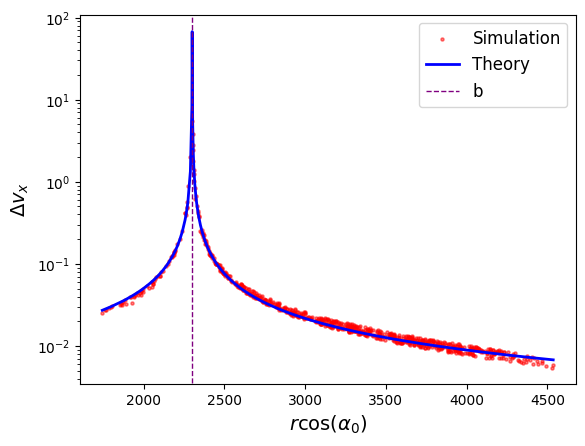

In [191]:
x0_sorted = np.array(sorted(x0))

delta_v_theory = 2 * G * m_p / vy_p / abs(b - x0_sorted)


# # calculate the x coordinate of delta_v = 0.01
# x1 = -2 * G * m_p / vy_p / 0.01 + b
# x2 = +2 * G * m_p / vy_p / 0.01 + b

plt.figure()
plt.scatter(x0, delta_vx, label='Simulation', color='red', s=5, alpha=0.5)
plt.plot(x0_sorted, delta_v_theory, label='Theory', color='blue', linewidth=2, linestyle='-')
# plt.hlines(0.01, b-3000, b+3000, color='green', label=r'$\Delta v = 0.01$', linewidth=1, linestyle='-.')
plt.axvline(b, 5e-3, 1e1, color='purple', linewidth=1, linestyle='--', label='b')
plt.legend(fontsize=12)
plt.xlabel(r'$r \cos(\alpha_0)$', fontsize=14)
plt.ylabel(r'$\Delta v_x$', fontsize=14)
plt.yscale('log')
